# Lab 04 - Clustering


## 0 - Goal of the Workshop
The goal of this workshop is to show the main principles of Clustering, in an interactive and
educational context. We will talk about Clustering basic definitions, Clustering algorithms and methods to evaluate their performance.
Each section contains questions and small exercises to grasp better each of the explained concepts.

## 1 - Introduction

### Supervised Learning VS Unsupervised Learning
***Machine Learning*** is a field of Artificial Intelligence used to make systems learn a specific behaviour (classification, regression, etc...) starting from data. To do so, data can be "labeled" - associated to some extra information like a numerical value or a category - and the involved algorithm is required to learn a mapping from each data input to these labels, an approach called ***Supervised Learning***.
However, sometimes labels are not available, or we want to have insights on the known data rather than getting predictions. ***Unsupervised Learning*** algorithms come in help, since they can learn patterns from unlabeled data, without needing any extra information

### Unsupervised Learning: use cases
Unsupervised Learning can be used in several scenarios:
   - customer segmentation: dividing customers in groups based on purchase history/browsing patterns (without knowing the number of customer types)
   - anomaly detection: revealing data points which deviate significantly from the others
   - document categorization: organizing text documents into categories based on content similarity

### Clustering
***Clustering*** is a type of Unsupervised Learning which consists in finding groups of data objects, called *clusters*, such that elements within the same cluster are similar/related to one another and are different to the ones belonging to other clusters. Actually, the definition of cluster can vary based on the type of algorithm used; some examples:
- ***center-based*** $\rightarrow$ a cluster is the set of objects closest to its center; the center can be defined in several ways, for example as the *centroid* - the average of the points within the relative cluster
    $$
        \bar{c_i} = (\bar{c_{i1}}, \bar{c_{i2}}, ..., \bar{c_{in}}) ,\quad \bar{c_{ij}} = \frac{1}{n}\sum\limits_{k=1}^{n}x_{kj}
    $$
    Where $\bar{c_{ij}}$ is the j-th component of the cluster i's centroid, and $x_{kj}$ is the j-th component of the k-th point of the cluster i
- ***density-based*** $\rightarrow$ a cluster is a high-density region of points; the separation among clusters is represented by low-density regions

<p align="center">
  <img src="./images/typesOfClusters.png" alt="centerBasedVsDistanceBased" width=700 />
</p>


## 2 - 📂 Loading and preparing the Data

To apply clustering algorithms, we first need to choose a ***dataset*** - a structured collection of data usually organized in a tabular format. In this case:
- each row corresponds to an element of the dataset called *data point* (a flower, a person, a document etc...)
- each column corresponds to a *feature* of that data point (age or height for a person, word count for a document etc...); there can be an extra column representing the *class*, that is the category each data point belongs to (but for clustering we don't need it!)

In Python, such two-dimensional table-like structure can be represented with a *DataFrame*, a class coming from the *Pandas* library.

[pandas.DataFrame documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) |
[10 minutes to Pandas](https://pandas.pydata.org/docs/user_guide/10min.html)

<p align="center">
  <img src="./images/dataFrame.png" alt="DataFrame" />
</p>

In [64]:
# import dependencies
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The chosen dataset is called Iris. ***Iris*** is a pretty small and common dataset containing the description about the types of iris plant. The dataset is made of 3 equally distributed classes, with information about sepal and petal width/length.
### Loading the dataset

To load the Iris dataset we can exploit the ***Scikit-Learn*** library and in particular the ```load_iris()``` method: this method easily gets the dataset as a DataFrame (with the option ```as_frame = True```). The returned object contains:
- *data* $\rightarrow$ DataFrame with only feature columns
- *target* $\rightarrow$ Series (one dimensional array holding data of any type) with only the target (class) column
- *frame* $\rightarrow$ DataFrame combining *data* and *target*
- *feature_names* $\rightarrow$ list of the features' names
- *target_names* $\rightarrow$ list of the classes' names

Scikit-Learn is fundamental for this lab, since it provides support not only for dataset loading, but also for classification, preprocessing, model evaluation, clustering and much more.

[Scikit-Learn](https://scikit-learn.org/stable/)

In [65]:
# load the dataset
iris = load_iris(as_frame=True)
# create a DataFrame with only features (no target)
iris_df = iris.data

print("Iris.data is of type {}".format(type(iris.data)))
print("Iris.frame is of type {}".format(type(iris.frame)))
print("Iris target: ")
print(iris.target)
print("Iris class names: {}".format(iris.target_names))
print("Iris feature names: {}".format(iris.feature_names))


Iris.data is of type <class 'pandas.core.frame.DataFrame'>
Iris.frame is of type <class 'pandas.core.frame.DataFrame'>
Iris target: 
0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64
Iris class names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### Initial feature visualization and distributions
Visualizing the features is fundamental not only to have a general understanding of how the dataset is structured, but also to check if some preprocessing is required or not before applying clustering methods.

The ```display()``` method can be used to render a DataFrame object, with rows representing the entries of the dataset and the columns representing the features.

The ```describe()``` method of a DataFrame object is a statistics function containing a lot of useful information, like:
- *count*: number of non-null values for each column
- *mean*: mean of the values in each column
- *std*: standard deviation of the values in each column

The method ```Series.value_counts()``` returns counts for each unique value of the Series object; it can be used to check the number of samples per class, which can give insights about the dataset distribution.

[DataFrame.describe()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe) | [[Series.value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html)

In [66]:
# feature visualization
display(iris_df)
display(iris_df.describe().T)

class_distribution = iris.target.value_counts()
print(class_distribution)

distr_df = pd.DataFrame({
    'Class_name': iris.target_names,
    'class_count': class_distribution.values,
})

display(distr_df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


target
0    50
1    50
2    50
Name: count, dtype: int64


,Class_name,class_count
0,setosa,50
1,versicolor,50
2,virginica,50


To further analyze the data distribution we can plot histograms, for single-feature distributions, and pairplots, for pairwise-feature distributions:
#### ***Histogram***

<p align="center">
    <img src="./images/histogram.png" alt="Alt text" width="700"/>
</p>

A histogram is a graphical representation of the distribution of a single numerical variable. On the x-axis there is the range of values that variable can take, divided in contiguous intervals or ***bins***; on the y-axis there is, for each bin, the number of times the variable took a value inside the bin's range (it can be both raw counts or expressed as a probability density between 0 and 1). It's useful to understand what is the distribution of each feature of our dataset, a crucial information for feature scaling (we'll see this later...)

#### ***Pairplot***

<p align="center">
  <img src="./images/pairplot.png" alt="pairplot" />
</p>

A pairplot is similar to a histogram, but instead of representing the distribution of a single feature, it represents all possible pair-wise feature distributions. In particular, for a dataset of $p$ numerical features, its pairplot will be a $p x p$ grid such that:
- cell (i, j) is a scatterplot showing the distribution of feature $i$ against the one of feature $j$
- cell (i, i) is a histogram showing the distribution of feature $i$

Pairplots are very important for clustering: they give us an idea of how are features correlated and which have the largest variability, an element that determines how spread our clusters will be (again we'll see this later...)

In python, histograms and pairplots can be created using methods from Pandas and Seaborn libraries:
- histogram $\rightarrow$ ```DataFrame.hist()```, specifying the number of bins ("bars" of the histogram)
- pairplot $\rightarrow$ ```Seaborn.pairplot()```

[DataFrame.hist()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html#pandas.DataFrame.hist) | [Seaborn.pairplot()](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

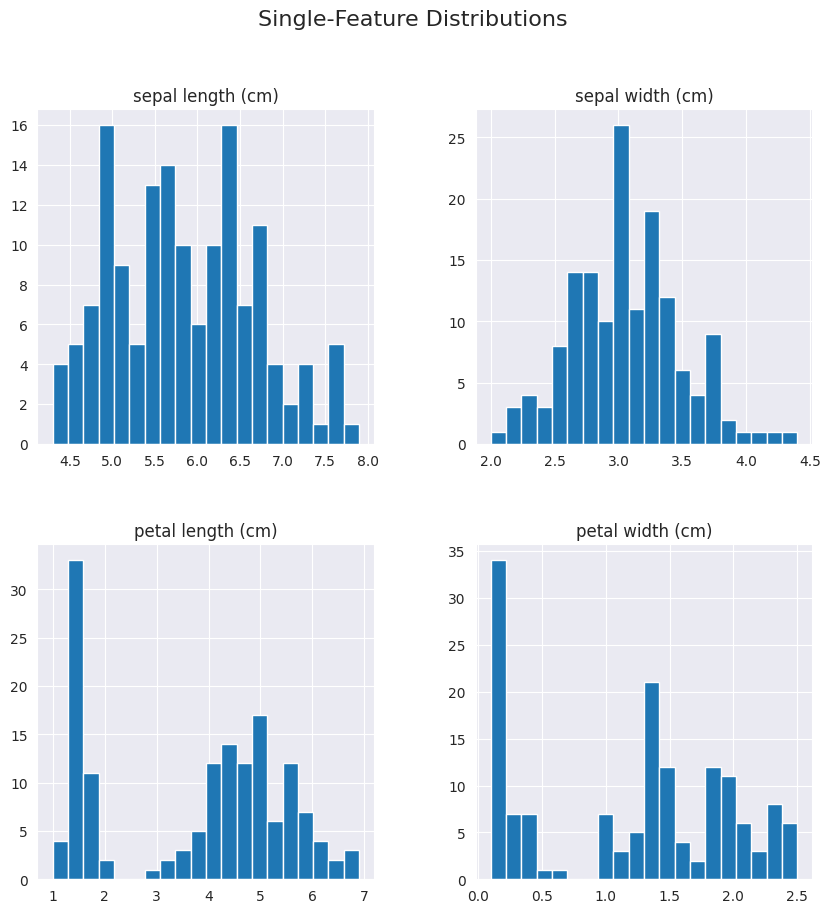

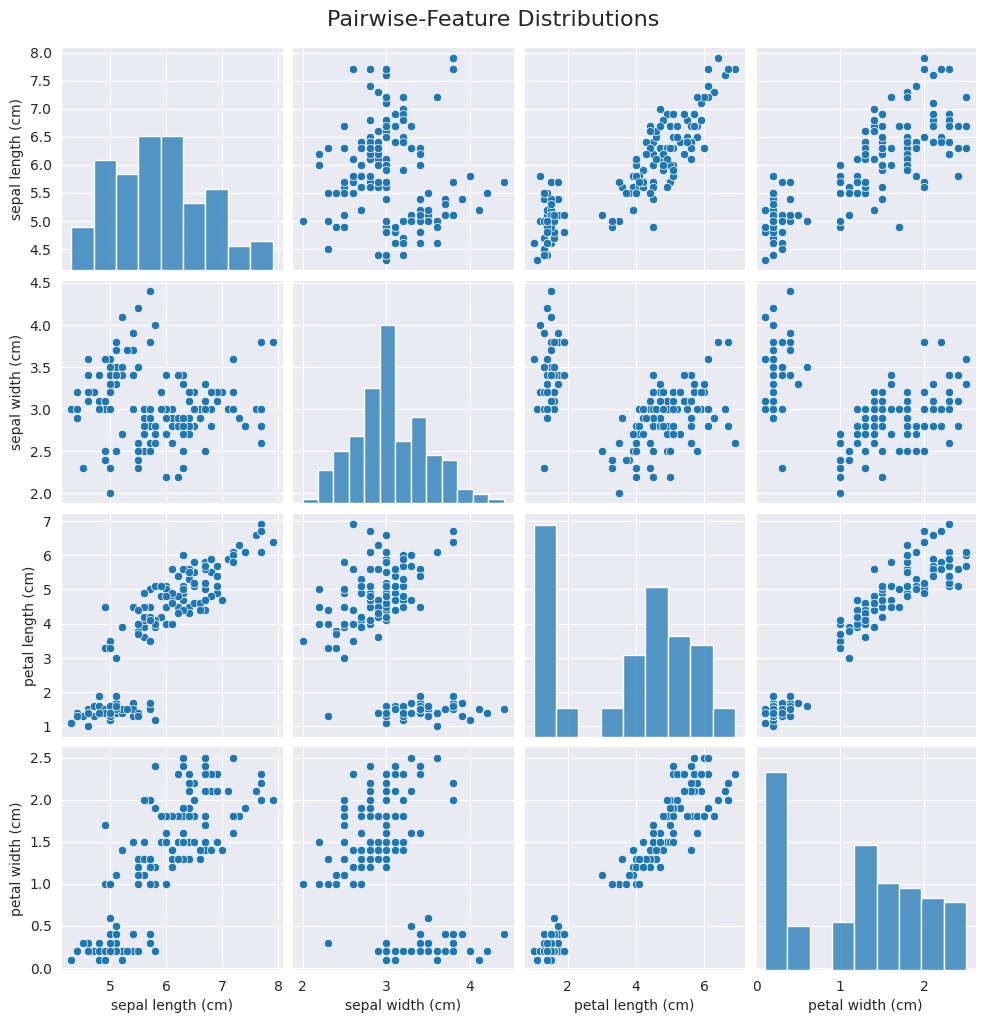

In [67]:
# histogram.png
iris_df.hist(bins=20, figsize=(10, 10))
plt.suptitle("Single-Feature Distributions", fontsize=16)
plt.show()

# pairplot
sns.pairplot(iris_df)
plt.suptitle("Pairwise-Feature Distributions", fontsize=16, y=1.02)
plt.show()


### The importance of Feature Scaling
Distance-based clusters are sensitive to feature value ranges (distance can be "dominated" by the presence of high values). That's why it's important to scale features before using any clustering algorithm. Since from the previous plots we observe a pseudo-normal trend in almost each feature, we can use ```sklearn.preprocessing.StandardScaler()``` class, so that each feature follows a Standard Normal distribution, with mean $\mu$ equal to 0 and standard deviation $\sigma$ equal to 1:

$$
x_{scaled} = \frac{x - \mu}{\sigma}
$$

Other possible approaches involve constraining each feature to a fixed range [$min$, $max$]:

$$
x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}} * (max - min) + min
$$
where $x_{min}$ and $x_{max}$ are respectively the minimum and maximum value for that feature. In python, we can obtain this result by using ```sklearn.preprocessing.MinMaxScaler()```.

[sklearn.preprocessing.StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) | [sklearn.preprocessing.MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scale the features
scaler = MinMaxScaler(feature_range=(-1, 1)) # by default the feature range is (0, 1)
iris_scaled_df = scaler.fit_transform(iris_df)
iris_scaled_df = pd.DataFrame(data=iris_scaled_df, columns=iris.feature_names)

print("Scaled with MinMaxScaler:")
display(iris_scaled_df.describe().T[['mean', 'std', 'min', 'max']])

# features follow gaussian-like distributions, so we'll stick with StandardScaler()
scaler = StandardScaler()
iris_scaled_df = scaler.fit_transform(iris_df)
iris_scaled_df = pd.DataFrame(data=iris_scaled_df, columns=iris.feature_names)

print("Scaled with StandardScaler:")
display(iris_scaled_df.describe().T[['mean', 'std', 'min', 'max']])

Scaled with MinMaxScaler:


,mean,std,min,max
sepal length (cm),-0.142593,0.460037,-1.0,1.0
sepal width (cm),-0.118889,0.363222,-1.0,1.0
petal length (cm),-0.065085,0.598406,-1.0,1.0
petal width (cm),-0.083889,0.635198,-1.0,1.0


Scaled with StandardScaler:


,mean,std,min,max
sepal length (cm),-4.736952e-16,1.00335,-1.870024,2.492019
sepal width (cm),-7.815970e-16,1.00335,-2.433947,3.090775
petal length (cm),-4.263256e-16,1.00335,-1.567576,1.785832
petal width (cm),-4.736952e-16,1.00335,-1.447076,1.712096


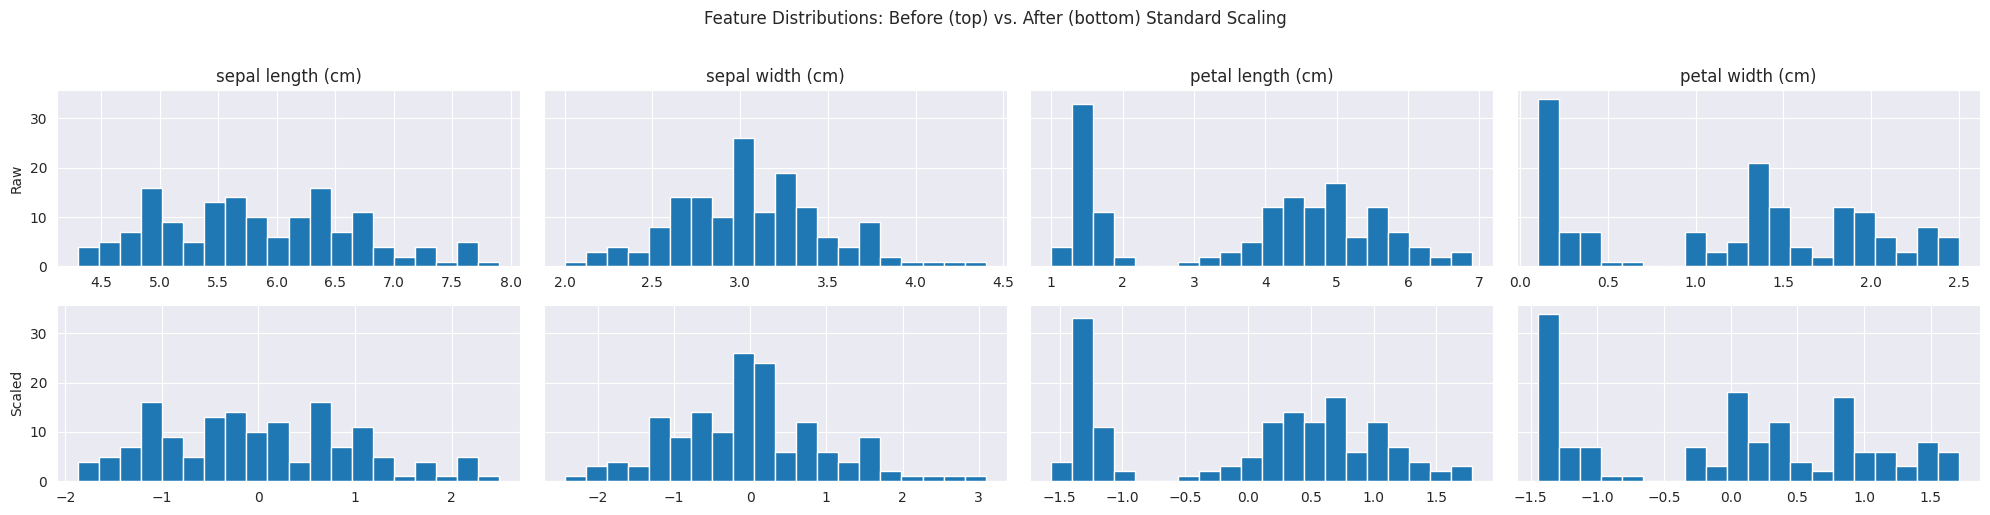

In [69]:
fig, axes = plt.subplots(2, len(iris_df.columns), figsize=(20, 5), sharey='row')

# raw histograms
for i, col in enumerate(iris_df.columns):
    axes[0, i].hist(iris_df[col], bins=20)
    axes[0, i].set_title(col)
    if i==0:
        axes[0, i].set_ylabel('Raw')

# scaled histograms
for i, col in enumerate(iris_scaled_df.columns):
    axes[1, i].hist(iris_scaled_df[col], bins=20)
    if i==0:
        axes[1, i].set_ylabel('Scaled')

fig.suptitle("Feature Distributions: Before (top) vs. After (bottom) Standard Scaling", y=1.02)
plt.tight_layout()
plt.show()

### 💡 ***Exercise: comparison between scaled and unscaled data on the Wine Dataset***
The Iris dataset is pretty common in machine learning, but it's not ideal to show the impact of scaling (there isn't enough diversity in the features' scales)

In [70]:
display(iris_df.describe().T[['mean', 'std', 'min', 'max']])

,mean,std,min,max
sepal length (cm),5.843333,0.828066,4.3,7.9
sepal width (cm),3.057333,0.435866,2.0,4.4
petal length (cm),3.758000,1.765298,1.0,6.9
petal width (cm),1.199333,0.762238,0.1,2.5


The Wine dataset, instead, has 13 features describing the chemical properties of three wine cultivars coming from the same region in Italy. Some of these features are significantly different in scale

In [71]:
from sklearn.datasets import load_wine

# load wine dataset
wine_df = load_wine(as_frame=True)
wine_target = wine_df.target
wine_df = wine_df.data

display(wine_df.describe().T[['mean', 'std', 'min', 'max']])

,mean,std,min,max
alcohol,13.000618,0.811827,11.03,14.83
malic_acid,2.336348,1.117146,0.74,5.80
ash,2.366517,0.274344,1.36,3.23
alcalinity_of_ash,19.494944,3.339564,10.60,30.00
magnesium,99.741573,14.282484,70.00,162.00
total_phenols,2.295112,0.625851,0.98,3.88
flavanoids,2.029270,0.998859,0.34,5.08
nonflavanoid_phenols,0.361854,0.124453,0.13,0.66
proanthocyanins,1.590899,0.572359,0.41,3.58
color_intensity,5.058090,2.318286,1.28,13.00


In this **exercise** we demonstrate the effect of feature scaling by computing the Euclidean distance from a query point to two other points sampled from the Wine dataset, both before and after scaling. We'll see that the query's nearest neighbor changes after switching from the unscaled to the scaled setup, proving that without scaling high range features are implicitly treated as more important than low range ones.
The Euclidean distance between two points is defined as the norm of the difference between those points:
$$
d(x,y) = || x - y ||_2 = \sum\limits_{i = 1}^n (x_i - y_i)^2
$$

In Python, the Euclidean distance can be easily computed using ```numpy.linalg.norm()```.
To get a sample given its index in the dataset, we can instead use ```DataFrame.iloc[index]```, by specifying the ```index``` term; note that we can also get more samples together by replacing the single index with the list of indexes corresponding to the desired data points, and in particular we can use ```DataFrame.iloc[list_of_indexes]``` by specifying the ```list_of_indexes``` term.

[numpy.linalg.norm documentation](https://numpy.org/doc/2.1/reference/generated/numpy.linalg.norm.html) |
[DataFrame.iloc[] documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0


Before scaling: 
d_AB = 31.265012394048398, d_AC = 35.27497696668277
Nearest neighbor to A: B 



,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.095423,0.513134,1.264724,0.613139,1.411516,-0.074125,0.419832,1.069045,1.168975,-0.091806,0.392232,1.357553,1.372813
1,-1.322332,0.884713,-1.180409,-1.410220,-0.630141,-1.185999,-1.379448,0.267261,-1.273779,-1.176259,0.980581,-1.021978,-0.392232
2,0.226909,-1.397847,-0.084315,0.797081,-0.781375,1.260124,0.959616,-1.336306,0.104805,1.268064,-1.372813,-0.335575,-0.980581


After scaling: 
d_AB = 6.450422595379692, d_AC = 5.781712902205751
Nearest neighbor to A: C


,Unscaled,Scaled
alcohol,1.03,2.417755
malic_acid,0.07,0.371580
ash,0.29,2.445133
alcalinity_of_ash,4.40,2.023360
magnesium,27.00,2.041656
total_phenols,0.15,1.111874
flavanoids,0.30,1.799280
nonflavanoid_phenols,0.02,0.801784
proanthocyanins,1.01,2.442754
color_intensity,1.26,1.084453


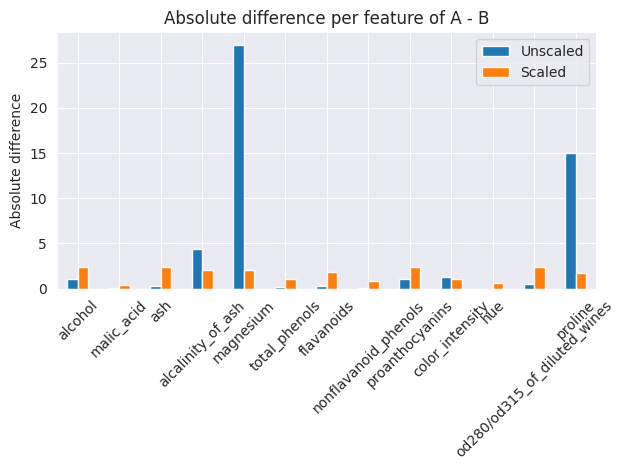

,Unscaled,Scaled
alcohol,0.37,0.868514
malic_acid,0.36,1.910981
ash,0.16,1.349039
alcalinity_of_ash,0.40,0.183942
magnesium,29.00,2.192890
total_phenols,0.18,1.334249
flavanoids,0.09,0.539784
nonflavanoid_phenols,0.06,2.405351
proanthocyanins,0.44,1.064170
color_intensity,1.58,1.359870


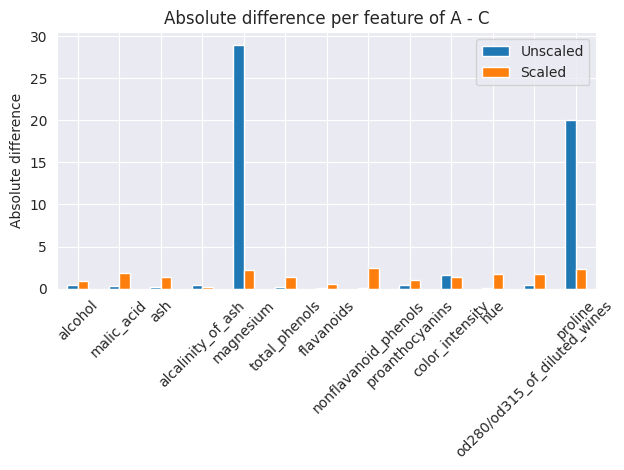

In [72]:
import numpy as np

# sample three points (A, B, C) from the wine dataset
indexes = [0, 1, 9]
samples = wine_df.iloc[indexes]
display(samples)

# compute the Euclidean distance between A and B, and between A and C
d_AB = np.linalg.norm(samples.iloc[0] - samples.iloc[1])
d_AC = np.linalg.norm(samples.iloc[0] - samples.iloc[2])
print("Before scaling: ")
print("d_AB = {}, d_AC = {}".format(d_AB, d_AC))
print("Nearest neighbor to A: {} \n".format("B" if d_AB < d_AC else "C"))

scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)
scaled_samples_df = pd.DataFrame(data=scaled_samples, columns=wine_df.columns)
display(scaled_samples_df)

d_AB = np.linalg.norm(scaled_samples_df.iloc[0] - scaled_samples_df.iloc[1])
d_AC = np.linalg.norm(scaled_samples_df.iloc[0] - scaled_samples_df.iloc[2])
print("After scaling: ")
print("d_AB = {}, d_AC = {}".format(d_AB, d_AC))
print("Nearest neighbor to A: {}".format("B" if d_AB < d_AC else "C"))

# plot the absolute differences per feature to further see the implicit importance of unscaled high-range features
abs_diff_AB = abs(samples.iloc[0] - samples.iloc[1])
abs_diff_AB_scaled = abs(scaled_samples_df.iloc[0] - scaled_samples_df.iloc[1])

abs_diff_AB_df = pd.DataFrame(
    np.array([abs_diff_AB, abs_diff_AB_scaled]).T,
    columns = ["Unscaled", "Scaled"],
    index = wine_df.columns
)

display(abs_diff_AB_df)

abs_diff_AB_df.plot(kind="bar")
plt.title("Absolute difference per feature of A - B")
plt.ylabel("Absolute difference")
# rotate x-axis labels for better visualization
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

abs_diff_AC = abs(samples.iloc[0] - samples.iloc[2])
abs_diff_AC_scaled = abs(scaled_samples_df.iloc[0] - scaled_samples_df.iloc[2])

abs_diff_AC_df = pd.DataFrame(
    np.array([abs_diff_AC, abs_diff_AC_scaled]).T,
    columns = ["Unscaled", "Scaled"],
    index = wine_df.columns
)

display(abs_diff_AC_df)

abs_diff_AC_df.plot(kind="bar")
plt.title("Absolute difference per feature of A - C")
plt.ylabel("Absolute difference")
# rotate x-axis labels for better visualization
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## 3 - 🔍 Exploring the Data Structure

So far we've seen how to visualize the single features of the Iris dataset, which can be useful to understand correlations and distributions. However, detecting broader patterns and potential clusters is much harder, since the dataset lies in a 4-dimensional space. This is where **Dimensionality reduction** methods come in help: with them, it's possible to "squeeze" the data structure into a 2-dimensional space, while preserving (as much as possible) the relationships between data points.

### PCA (Principal Component Analysis)
1) finds the directions along which data varies the most (*principal components*); each direction is a vector computed as a linear combination of each feature, with each coefficient representing the impact of the feature on that direction;
2) projects data points onto the first two of these components, obtaining a 2D representation tha captures the most important variability patterns in the dataset;

<p align="center">
  <img src="./images/PCA_original.png" alt="PCA" />
</p>

In Python, we can use the ```sklearn.decomposition.PCA``` class to initialize a PCA object specifying the number of principal components we want to project the data points on (```n_components```); then, the reduced dataset can be obtained by passing it (as a DataFrame object) to ```PCA().fit_transform()```. We can also visualize the principal components (```PCA().components_```) using the ```arrow()``` method from Matplotlib. Note that, since PCA is represented in a 2D space, we cannot directly plot the principal components (they are 4D vectors in the original feature space); instead, we can plot the directions of variability for each feature of the dataset.

[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]


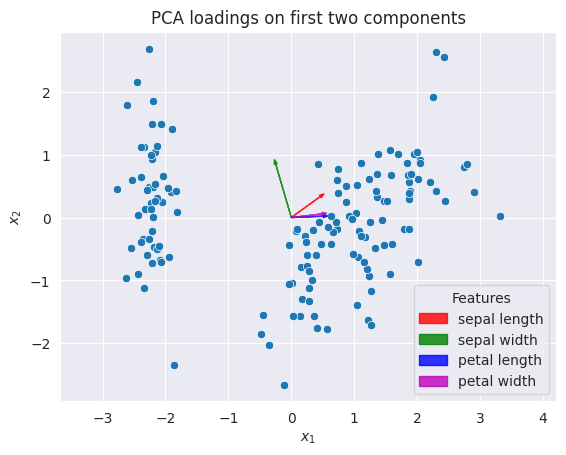

In [73]:
from sklearn.decomposition import PCA
#import matplotlib.pyplot as plt (already imported before)

pca = PCA(n_components=2)
iris_pca = pca.fit_transform(iris_scaled_df)
sns.scatterplot(x=iris_pca[:, 0], y=iris_pca[:, 1])

pca_comp = pca.components_
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
colors = ['r', 'g', 'b', 'm']
print(pca_comp)
for i, (f, c) in enumerate(zip(features, colors)):
    plt.arrow(0, 0, pca_comp[0, i], pca_comp[1, i], color=c, alpha=0.8, head_width=0.05, length_includes_head=True, label=f)

plt.title("PCA loadings on first two components")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend(title="Features", loc="best")
plt.grid(True)
plt.axis('equal')
plt.show()

#### ***Why does this work?***
Variability is related to ***informativity***: the more the data points are spread out, the higher will be the number of patterns they contain. If the reduced representation is able to capture most of the variability in the original dataset, (e.g.: it "explains the variance" sufficiently) it can capture well the underlying information; as a result, it can preserve the original structures and relationships among data points.
#### ***How do we know if two components are enough to capture most of the variability?***
We can check ```PCA().explained_variance_ratio_```, which returns the percentage of variance captured by a principal component, for each of the components. As we can see from the example below, two components can explain most of the variance in the dataset (96% of it):


In [74]:
pca = PCA(n_components=4)
pca.fit(iris_scaled_df)
evr = pd.Series(pca.explained_variance_ratio_,
                index=[f"PC{i+1}" for i in range(4)])
print(evr.round(3))
print("Percentage of variance captured by the first two components: {}".format(evr.iloc[0].round(3) + evr.iloc[1].round(3)))

PC1    0.730
PC2    0.229
PC3    0.037
PC4    0.005
dtype: float64
Percentage of variance captured by the first two components: 0.959


#### ***PCA and Pairplots***
If we compare the (petal length, sepal width) pairplot of the iris dataset, we can notice a lot of similarities with the previous PCA plot. This means that most of the variability patterns come from those two features, which have also the highest ***loading*** (weight/coefficient of the principal components) among all the other features. This last detail can be easily seen by creating a DataFrame containing loadings (```PCA().components_```) and plotting them as bars with ```DataFrame.plot(kind="bar")```.

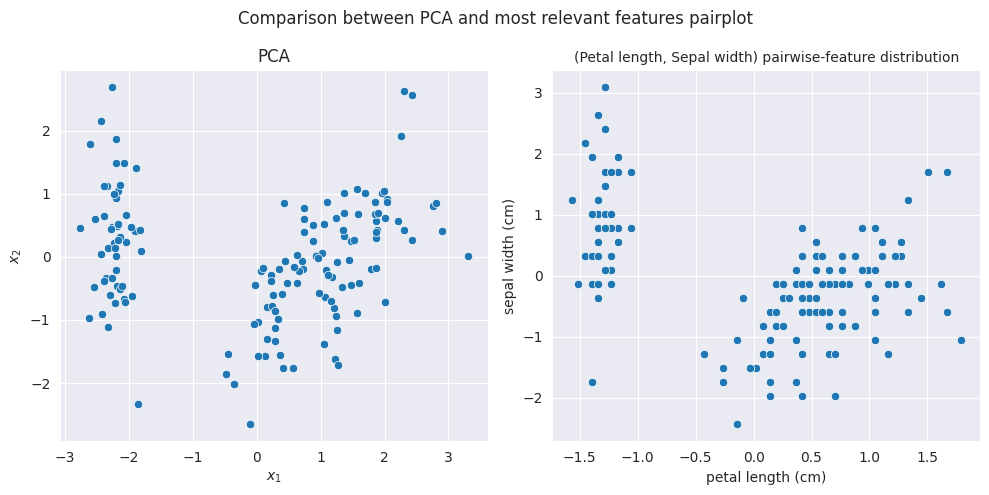

,PC1,PC2
sepal length (cm),0.521066,0.377418
sepal width (cm),-0.269347,0.923296
petal length (cm),0.580413,0.024492
petal width (cm),0.564857,0.066942


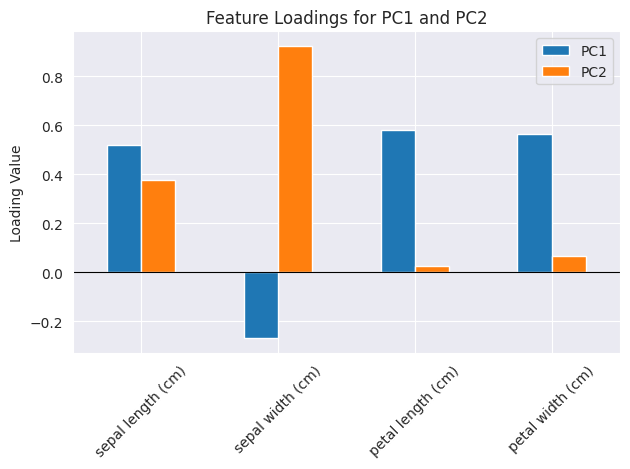

Most relevant loading for PC1: petal length (cm) (0.5804130957962941)
Most relevant loading for PC2: sepal width (cm) (0.9232956595407142)


In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

pca = PCA(n_components=2)
iris_pca = pca.fit_transform(iris_scaled_df)
sns.scatterplot(x=iris_pca[:, 0], y=iris_pca[:, 1], ax=axes[0])
axes[0].set_title("PCA")
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")

sns.scatterplot(iris_scaled_df, x="petal length (cm)", y="sepal width (cm)", ax=axes[1])
axes[1].set_title("(Petal length, Sepal width) pairwise-feature distribution", fontsize=10)
axes[1].set_xlabel("petal length (cm)")
axes[1].set_ylabel("sepal width (cm)")

plt.suptitle("Comparison between PCA and most relevant features pairplot")
plt.tight_layout()
plt.show()


loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=iris_scaled_df.columns
)
display(loadings_df)

loadings_df.plot(kind="bar")
plt.title("Feature Loadings for PC1 and PC2")
plt.ylabel("Loading Value")
# rotate x-axis labels for better visualization
plt.xticks(rotation=45)
# add a black line at y = 0 to clearly distinguish between positive and negative loadings
plt.axhline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

print("Most relevant loading for PC1: {} ({})".format(loadings_df["PC1"].idxmax(), max(loadings_df["PC1"])))
print("Most relevant loading for PC2: {} ({})".format(loadings_df["PC2"].idxmax(), max(loadings_df["PC2"])))

### t-SNE (t-Stochastic Neighbor Embedding)
PCA is a fast and reliable dimensionality reduction technique, but it can struggle with datasets containing highly non-linear patterns. For these scenarios we can instead use ***t-SNE (t-Stochastic Neighbor Embedding)***, which can better capture non-linearities.
while PCA focuses on preserving global structures, t-SNE focuses on preserving local neighborhoods among data points. In particular:
1) for each point, builds a Gaussian conditional probability distribution in the original feature space based on the distances between points: closer points will have a high probability, distant points will have a low probability. The number of points to be considered "close" is specified with a hyperparameter called ***perplexity***

<p align="center">
  <img src="./images/tsneVisual.png" alt="TSNEexplained" />
</p>

2) in the reduced (2D) feature space creates a Student-t distribution, which has "heavier tails" with respect to a Gaussian one: letting significantly distant points have a non-negligible probability in the low dimensional space avoids having these points squeezed close together, a common scenario that happens when reducing dimensions (e.g.: reducing degrees of freedom)

<p align="center">
  <img src="./images/tsneVisual2.png" alt="TSNEexplained2" />
</p>

In Python, we can proceed in a way similar to PCA: after creating a t-SNE object with ```sklearn.manifold.TSNE(n_components)```, specifying again ```n_components=2```, the reduced dataset is obtained by passing it (as a DataFrame object) to ```TSNE().fit_transform()```

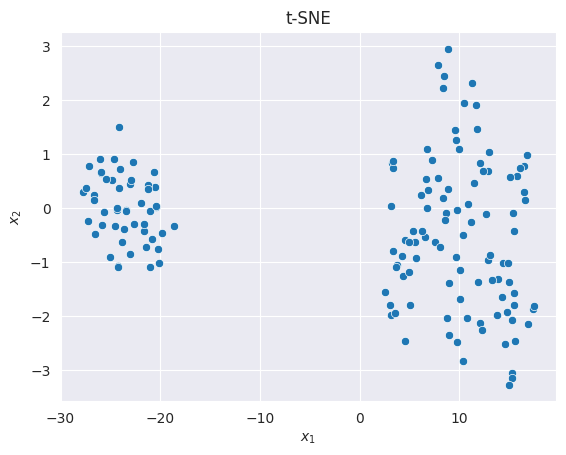

In [76]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
iris_tsne = tsne.fit_transform(iris_scaled_df)
sns.scatterplot(x=iris_tsne[:, 0], y=iris_tsne[:, 1])
plt.title("t-SNE")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()


#### ***Why does this work?***
Because it effectively shifts the dimensionality reduction problem to a probability matching task: by reconstructing a probability distribution in the reduced space that is as close as possible to the original one, we are also preserving the original structural patterns and relationships among data points (especially local neighborhoods).
### 💡 ***Exercise: the role of perplexity in t-SNE***
As briefly mentioned, ***perplexity*** represents the number of neighbors each data point considers as mostly "relevant" when constructing the probability distribution in the high-dimensional space. Since it's a t-SNE hyperparameter, it can be tuned to obtain different results:
- low perplexity (5 - 30) $\rightarrow$ few points are important, so local structures/clusters are well preserved
- high perplexity (30 - 50) $\rightarrow$ a lot of points are important, so global structures are preserved more; if too high, it can merge together some local clusters (***oversmooth***) or change their shape and/or position

Now, try to use t-SNE with different perplexity values (es.: 5, 30, 50, 100, 130) and see how the tradeoff between preserving local and global structures is handled.


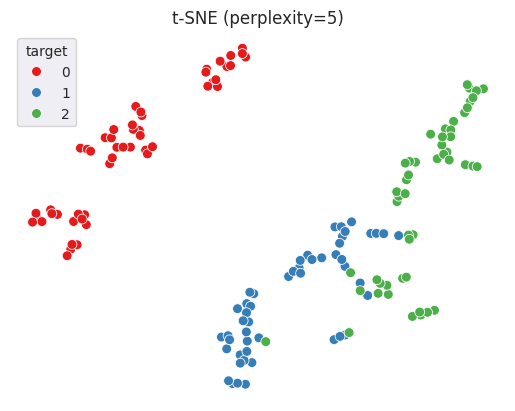

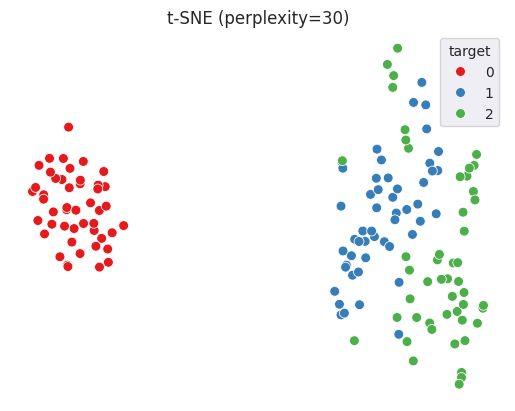

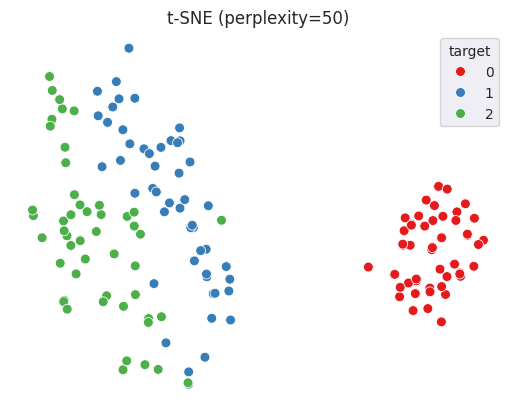

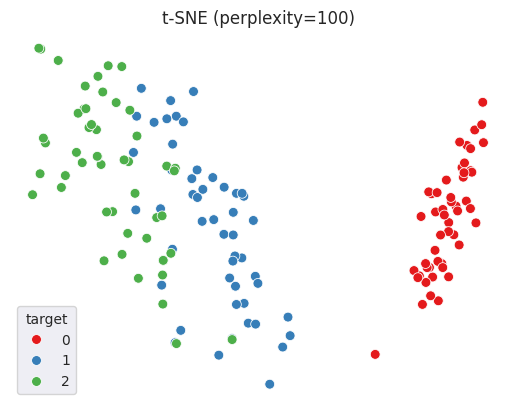

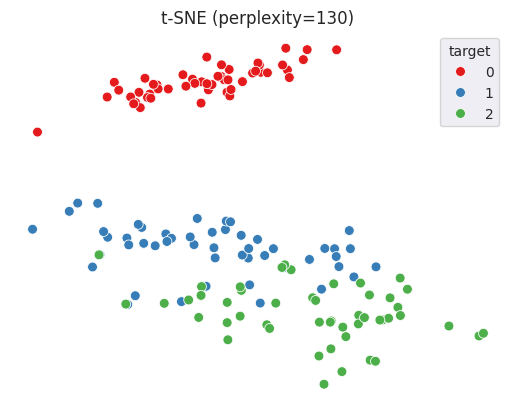

In [77]:
perplexity_values = [5, 30, 50, 100, 130]

for perp in perplexity_values:
    tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
    emb = tsne.fit_transform(iris_scaled_df)

    sns.scatterplot(x=emb[:,0], y=emb[:,1],
                    hue=iris.target, palette='Set1', s=50)
    plt.title(f"t-SNE (perplexity={perp})")
    plt.axis('off')
    plt.show()


### PCA vs t-SNE: what should you use and when? 🤔
| **Feature**            | **PCA**                                                                                                                                                                                                                        | **t-SNE**                                                                                                                                                             |
| ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Interpretability**   | High – Principal components are linear combinations of original features, where each coefficient (*loading*) expresses the relevance of the corresponding feature in that component. | Low – Embedding axes are arbitrary and have no direct meaning in the original feature space.                                                                          |
| **Non-linearity**      | Struggles when feature pairwise distributions are highly non-linear.                                                                                                                                                           | Excels at capturing complex, non-linear relationships (local clusters).                                                                                               |
| **Determinism**        | Deterministic – Same input → same output every time.                                                                                                                                                                           | Stochastic – Results vary with random seed, which can lead to slightly different cluster layouts each time.                                                           |
| **Computational Cost** | Low – Requires only computation of vectors and projections, making it fast even on large datasets.                                                                                                                             | High – Requires constructing two probability distributions (in high and low dimensions) and solving an optimization problem to match them.                            |
| **Best Use Cases**     | • When you need interpretable features<br>• When data is mostly linear<br>• To visualize global structures (variance)                                                                                                          | • To visualize hidden local (non-linear) structures in low-dimensional spaces<br>• When the dataset is small or after an initial PCA reduction for better performance |



## 4 - 🔗 Clustering Algorithms

Now it's time to see some of the most common algorithms for clustering. In particular, we'll see:
- K-means
- DBSCAN
- Hierarchical clustering

### K-Means
It's a *partitional* clustering algorithm (divides data points in non-overlapping sets such that each point belongs exactly to one set).

**Algorithm steps:**
1) k points are randomly chosen as initial *centroids*, each of them with a relative label
2) each point receives the label corresponding to the nearest centroid
3) centroids are updated using the points with the same label; the process starts again from 2., until convergence

<p align="center">
  <img src="./images/Kmeans.png" alt="kmeans" width=800/>
</p>

The choice of $k$ is crucial: it determines how many clusters will be formed. Since we have three classes in our dataset, $k$ should be $3$.

### DBSCAN
It's a density-based partitional clustering algorithm. As a density-based method, it doesn't require specifying the number of clusters ($k$ in K-means), since each of them is identified by a high density region in the feature space.

**Algorithm steps:**

0. choose two hyperparameters:
   - *min_samples* $\rightarrow$ minimum number of points to form a dense region
   - $\varepsilon$ $\rightarrow$ neighborhood radius
1. identify *core points* $\rightarrow$ points having more than *min_samples* in their $\varepsilon$-neighborhood
2. identify *border points* $\rightarrow$ points having less than *min_samples* in their $\varepsilon$-neighborhood, but in a $\varepsilon$-neighborhood of a core point
3. identify *noise points* $\rightarrow$ all other points not classified as core or border
4. for each core point, assign to it a label and do the same for all the other points (excluding noise points) in its $\varepsilon$-neighborhood

<p align="center">
  <img src="./images/DBSCAN.png" alt="dbscan" />
</p>

### DBSCAN - Noise Detection
DBSCAN implicitly performs a noise/outlier detection, since points that are not part of a high density region are labelled with $-1$ and ignored in step 4). By tuning $\varepsilon$ and *min_samples*, we can leverage the level of sparsity and consequently the number of noise points detected

### Hierarchical clustering

***Hierarchical Clustering*** represents a different approach with respect to partitional clustering: it produces a set of nested clusters organized in a hierarchy tree. There are two types of hierarchical clustering, based on how clusters are built:
- **bottom-up** or **agglomerative** $\rightarrow$ starting with each data point as an individual cluster, at each step, the two closest clusters are merged; this process continues until the desired number of clusters is obtained (or alternatively until there is one cluster left)
- **top-down** or **divisive** $\rightarrow$ starting with one all-inclusive cluster, at each step, the "worst" cluster is split (for example, the most scattered/spread out); this process continues until the desired number of clusters is obtained (or alternatively until each cluster contains one point)

The hierarchy tree can be visualized as a **dendrogram**, a tree-like diagram tracking the sequence of merges or splits done by the algorithm

<p align="center">
  <img src="./images/dendrogram.png" alt="dendrogram" />
</p>

In agglomerative hierarchical clustering, to find the closest clusters we have to define a metric of cluster similarity, or **linkage method**:

<p align="center">
  <img src="./images/linkageMethods.png" alt="linkageMethods" />
</p>

**Algorithm steps (agglomerative version):**

0. Choose the linkage method and the **distance metric**, that tells us how to measure distance between data points (e.g.: Euclidean)

1. Start with each data point as its own cluster  
   → if there are *n* data points, you begin with *n* clusters

2. Compute the pairwise distance matrix $D$ between all current clusters $C_1, C_2, ...$:
    $$
    D_{ij} = d(C_i, C_j)
    $$

3. Merge the two clusters that are closest to each other (based on the chosen linkage method)

4. Update the distance matrix to reflect the new cluster

5. Repeat steps 3–4 until:
   - All points are merged into a single cluster (to form the full hierarchy), or
   - A desired number of clusters is reached (if specified)

6. *(Optional)* Cut the dendrogram at a chosen height  
   → the number of vertical lines intersected by the cut determines the number of clusters

<p align="center">
  <img src="./images/hierarchicalClustering.jpg" alt="hierarClust" width=800/>
</p>

To use these algorithms, we can exploit the implementations provided by Scikit-Learn:
- ```sklearn.cluster.KMeans```
- ```sklearn.cluster.DBSCAN```
- ```sklearn.cluster.AgglomerativeClustering```

[sklearn.cluster](https://scikit-learn.org/stable/api/sklearn.cluster.html#module-sklearn.cluster)


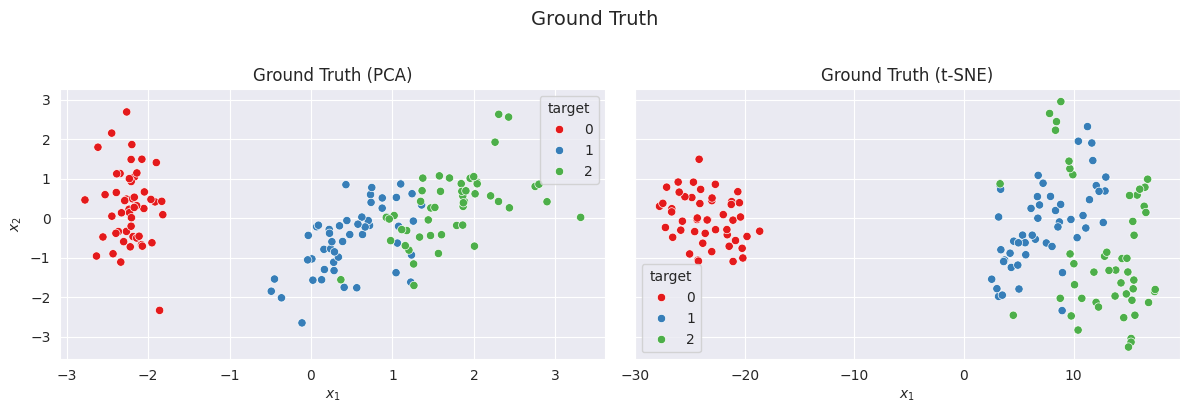

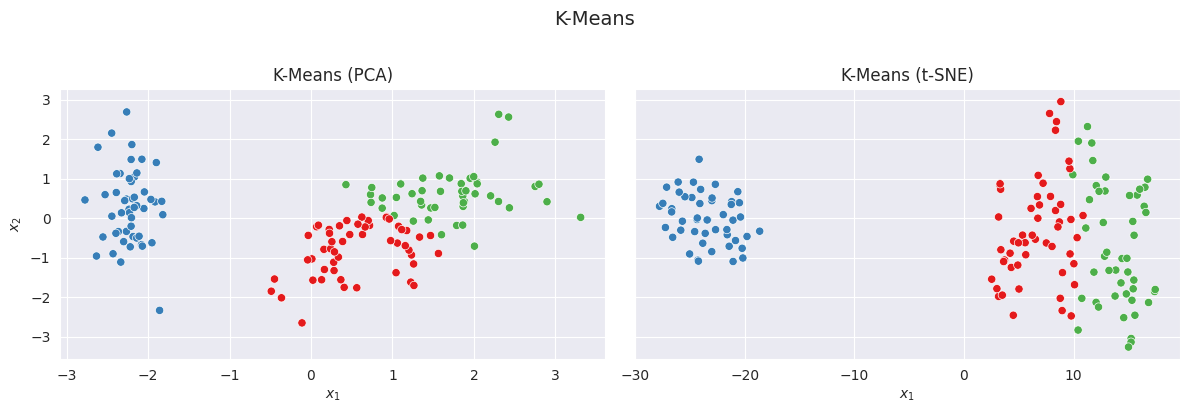

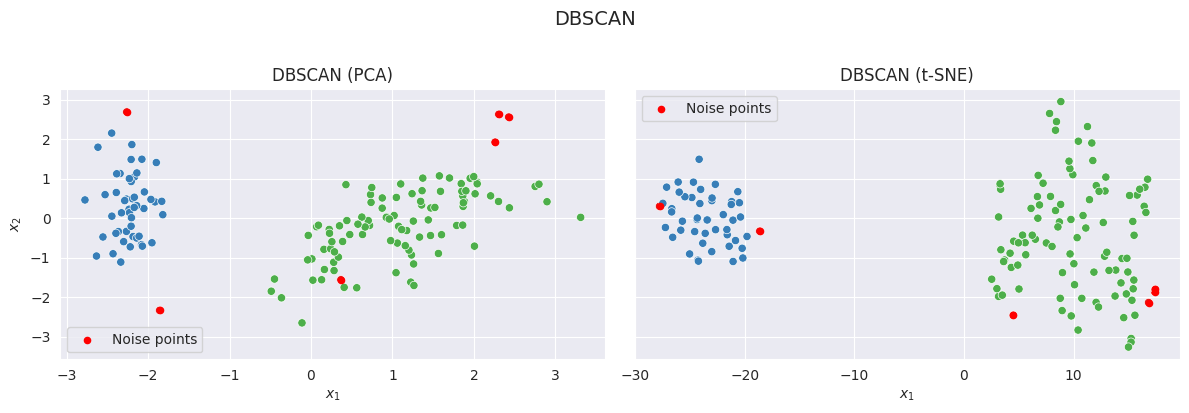

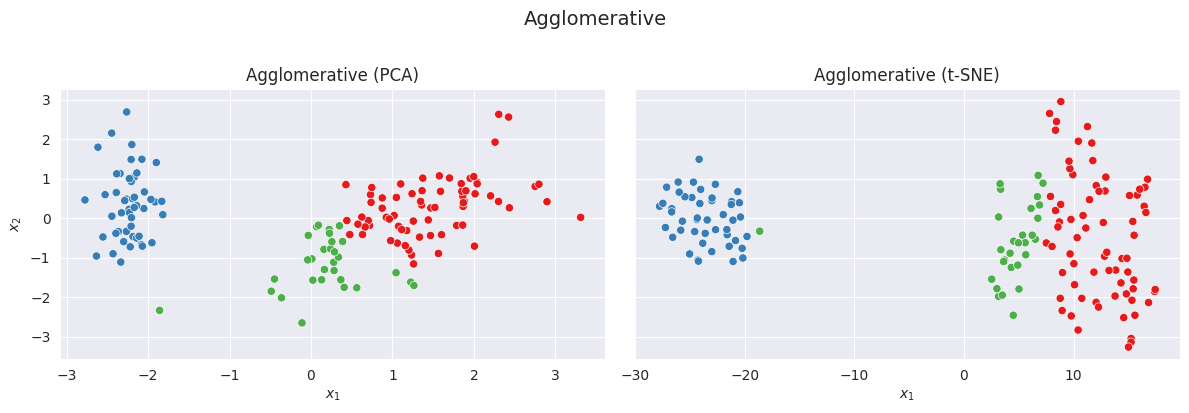

In [78]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


# K-Means
km = KMeans(n_clusters=3, random_state=0)
kmeans_labels = km.fit_predict(iris_scaled_df) # note that kmeans assigns label numbers randomly, since it does not know true labels

# DBSCAN
dbs = DBSCAN(eps=0.7, min_samples=5)
dbs_labels = dbs.fit_predict(iris_scaled_df)

labelings = {
    "Ground Truth": iris.target,
    "K-Means":      kmeans_labels,
    "DBSCAN":       dbs_labels,
}


# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(iris_scaled_df)

labelings["Agglomerative"] = agg_labels

for name, labels in labelings.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # PCA subplot
    sns.scatterplot(
        x=iris_pca[:, 0], y=iris_pca[:, 1],
        hue=labels, palette="Set1", ax=axes[0], legend=(name=="Ground Truth")
    )
    axes[0].set_title(f"{name} (PCA)")
    axes[0].set_xlabel("$x_1$")
    axes[0].set_ylabel("$x_2$")

    # t-SNE subplot
    sns.scatterplot(
        x=iris_tsne[:, 0], y=iris_tsne[:, 1],
        hue=labels, palette="Set1", ax=axes[1], legend=(name=="Ground Truth")
    )
    axes[1].set_title(f"{name} (t-SNE)")
    axes[1].set_xlabel("$x_1$")
    axes[1].set_ylabel("$x_2$")

    if name == "DBSCAN":
        noise_mask = (labels == -1)

        # Noise points on PCA
        axes[0].scatter(
            iris_pca[noise_mask, 0], iris_pca[noise_mask, 1],
            c='r', marker='o', s=20, label='Noise points'
        )
        # Noise points on t-SNE
        axes[1].scatter(
            iris_tsne[noise_mask, 0], iris_tsne[noise_mask, 1],
            c='r', marker='o', s=20, label='Noise points'
        )

        axes[0].legend(loc='best')
        axes[1].legend(loc='best')

    plt.suptitle(name, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

#### Silhouette-Score and Elbow-Method

The plots above show two common methods for determining the ideal number of clusters (`k`) for K-Means:

##### Elbow Method
- The **left plot** displays the *inertia* (within-cluster sum of squares) as a function of `k`.
- There is a clear **elbow at k = 3**, where the rate of decrease in inertia slows down significantly.
- This suggests that 3 clusters capture most of the structure in the data without overfitting.

##### Silhouette Score
- The **right plot** shows the *silhouette score*, which measures the cohesion and separation of clusters.
- The silhouette score peaks at **k = 2**, but drops slightly for **k = 3**, which still has a relatively high score.
- Since k = 2 may under-cluster the data, and k = 3 provides a good balance, **k = 3 is a reasonable and interpretable choice**.

**Conclusion**: Both methods point toward **k = 3** as a strong candidate for the number of clusters in this dataset.


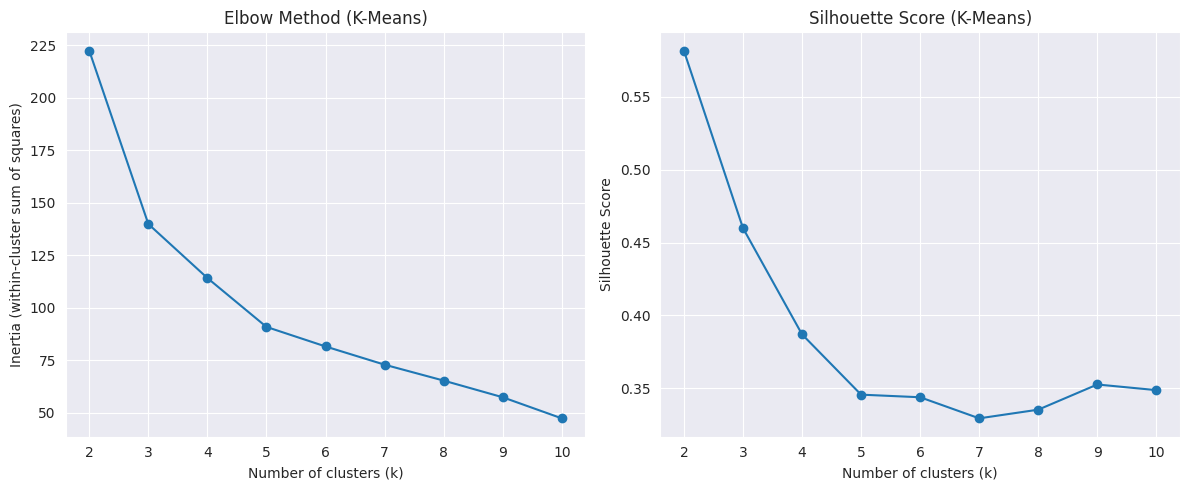

In [79]:
from sklearn.metrics import silhouette_score

# Range of k values to try
k_range = range(2, 11)

inertia = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(iris_scaled_df)
    
    inertia.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center
    silhouette_scores.append(silhouette_score(iris_scaled_df, labels))

# Plotting the Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method (K-Means)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.grid(True)

# Plotting Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score (K-Means)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


#### Dendrogram (Ward linkage)

The dendrogram above illustrates the process of **agglomerative hierarchical clustering** using **Ward linkage**.

##### How to interpret it:

- **Each leaf** at the bottom represents a single sample (data point).
- **Branches** show how clusters are formed by merging samples or other clusters.
- The **height** at which two branches merge reflects the **distance (dissimilarity)** between them.
- **Shorter vertical lines** mean that the merged clusters are more similar.
- The **tallest merge** (near distance = 27) represents the final combination of the two largest clusters.

##### Choosing the number of clusters:

To choose a number of clusters, draw a **horizontal cut** across the dendrogram.  
The number of vertical lines the cut intersects corresponds to the number of clusters.  
For example, cutting at **height ≈ 15** results in **3 clusters**.

This visualization helps understand both the **hierarchy** and the **structure** of the dataset.


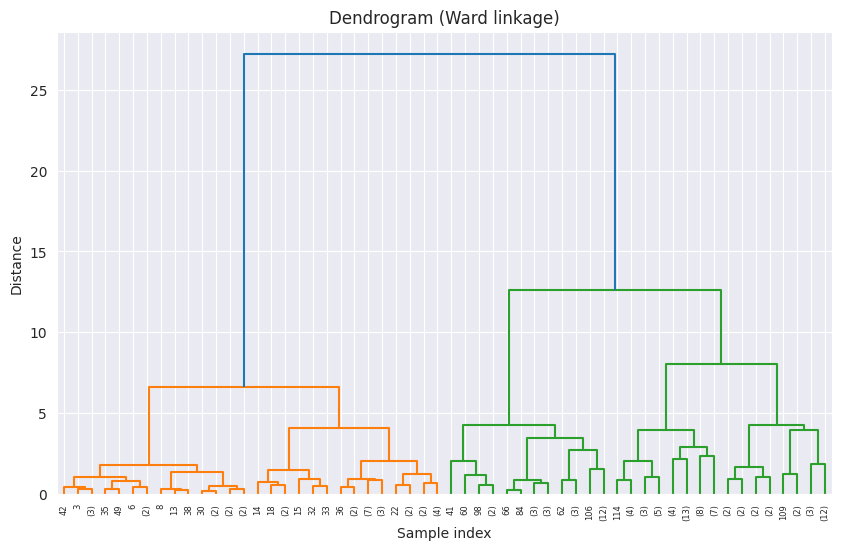

In [80]:

# Dendrogram explanation (using Ward linkage)
linked = linkage(iris_scaled_df, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Dendrogram (Ward linkage)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

Exercise

- By changing cut_height variable in the cell below states your chosen cut_height and why you picked it,
- includes the silhouette score and a screenshot of the 2-D plot,
- comments on any biological insight (e.g. whether species overlap).

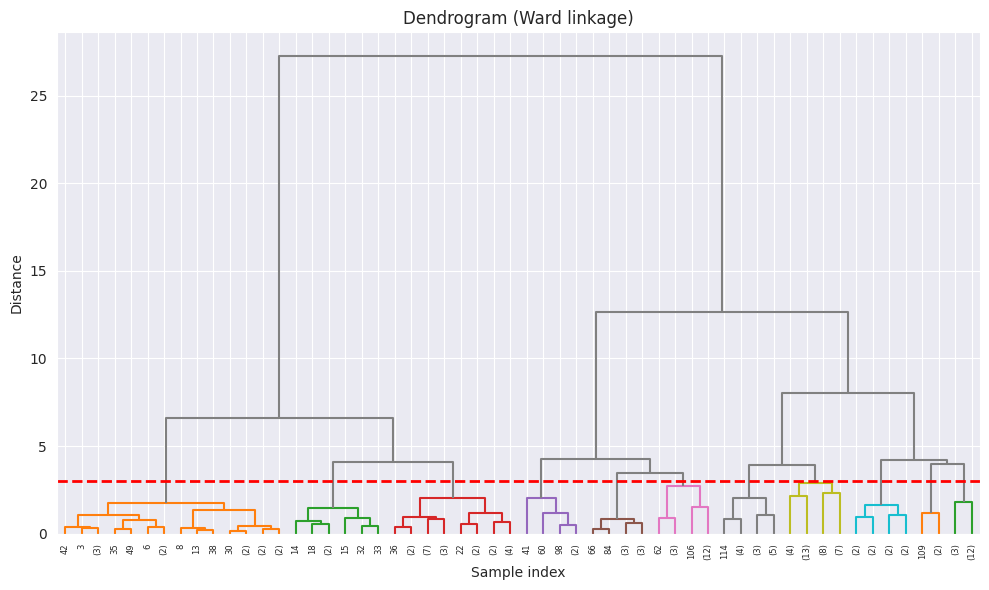

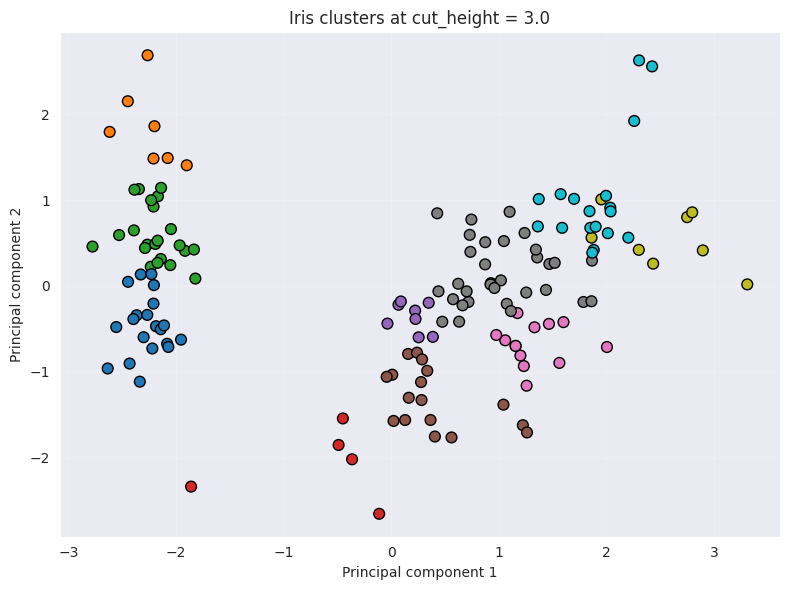

In [81]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

linked = linkage(iris_scaled_df, method="ward")

# === Change this value to experiment with different cuts =============
cut_height = 3.0
# =====================================================================

# --- Dendrogram -------------------------------------------------------
plt.figure(figsize=(10, 6))
dendrogram(
    linked,
    truncate_mode="level",      # show only the top levels to keep it tidy
    p=5,
    color_threshold=cut_height, # colour branches below the cut
    above_threshold_color="grey"
)
plt.axhline(y=cut_height, color="red", linewidth=2, linestyle="--")
plt.title("Dendrogram (Ward linkage)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# --- Cluster labels ---------------------------------------------------
cluster_labels = fcluster(linked, t=cut_height, criterion="distance")

# --- 2-D projection (PCA) --------------------------------------------
pca = PCA(n_components=2, random_state=42)
points_2d = pca.fit_transform(iris_scaled_df)

# --- Scatter plot coloured by cluster --------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(
    points_2d[:, 0],
    points_2d[:, 1],
    c=cluster_labels,
    cmap="tab10",
    s=60,
    edgecolor="k"
)
plt.title(f"Iris clusters at cut_height = {cut_height}")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



### Algorithms comparison

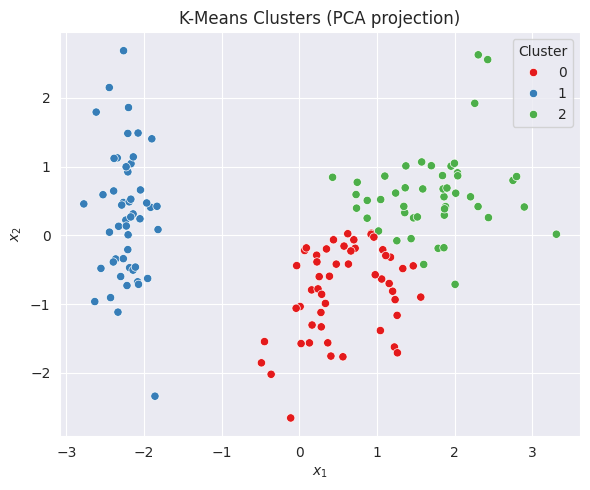

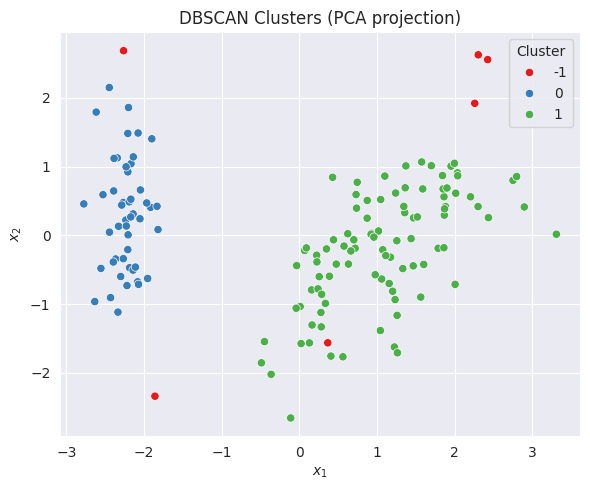

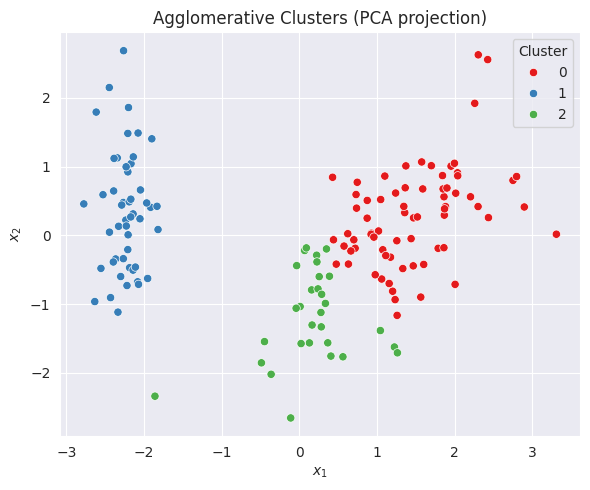

,Algorithm,Silhouette Score,Davies–Bouldin Index,Adjusted Rand Index,Normalized Mutual Info
0,K-Means,0.459948,0.833595,0.620135,0.659487
1,DBSCAN,0.601795,0.556837,0.540077,0.671165
2,Agglomerative,0.446689,0.803467,0.615323,0.675470


In [82]:
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary of clustering algorithms and their labels
clustering_results = {
    "K-Means": kmeans_labels,
    "DBSCAN": dbs_labels,
    "Agglomerative": agg_labels,
}

# Initialize metrics dictionary
metrics = []

# Evaluate each clustering method
for name, labels in clustering_results.items():
    # Filter noise points for internal validation if DBSCAN is used
    mask = labels != -1 if name == "DBSCAN" else slice(None)

    sil_score = silhouette_score(iris_scaled_df[mask], labels[mask]) if len(set(labels[mask])) > 1 else float('nan')
    db_index = davies_bouldin_score(iris_scaled_df[mask], labels[mask]) if len(set(labels[mask])) > 1 else float('nan')
    ari = adjusted_rand_score(iris.target, labels)
    nmi = normalized_mutual_info_score(iris.target, labels)

    metrics.append({
        "Algorithm": name,
        "Silhouette Score": sil_score,
        "Davies–Bouldin Index": db_index,
        "Adjusted Rand Index": ari,
        "Normalized Mutual Info": nmi,
    })

    # Visualization
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=iris_pca[:, 0], y=iris_pca[:, 1], hue=labels, palette="Set1")
    plt.title(f"{name} Clusters (PCA projection)")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend(title="Cluster", loc="best")
    plt.tight_layout()
    plt.show()

# Show metrics as table
import pandas as pd
df_metrics = pd.DataFrame(metrics)
df_metrics


We compared three clustering algorithms—**K-Means**, **DBSCAN**, and **Agglomerative Clustering**—using both internal and external evaluation metrics, along with PCA-based visualizations.

- **Silhouette Score**: Highest for **DBSCAN** (0.602), indicating the best cluster compactness and separation.
- **Davies–Bouldin Index**: Also lowest for **DBSCAN** (0.557), suggesting well-separated and distinct clusters.
- **Adjusted Rand Index (ARI)**: Slightly higher for **K-Means** (0.620), indicating better alignment with the ground truth labels.
- **Normalized Mutual Information (NMI)**: Best for **Agglomerative Clustering** (0.675), showing good label agreement.

PCA visualisations:

- The **K-Means** plot (see figure above) shows clearly separated clusters in PCA space, with relatively balanced shapes.
- In the corresponding plots for **DBSCAN** and **Agglomerative**, clusters may be more flexible or noise-aware (as in DBSCAN), depending on the underlying structure.


*Conclusion*

- **DBSCAN** offers the best **internal performance**, particularly for datasets with arbitrary shapes and noise.
- **K-Means** performs well when clusters are spherical and balanced.
- **Agglomerative Clustering** yields slightly lower internal scores, but strong external alignment via **NMI**.

Choosing the right method depends on the **data characteristics** and whether you prioritize **internal structure** or **label alignment**.


In [83]:
# Load Iris dataset
iris_bunch = load_iris()

# Convert to DataFrame
iris = pd.DataFrame(iris_bunch.data, columns=iris_bunch.feature_names)
iris['target'] = iris_bunch.target


===== K-Means Cluster Profiling =====
         sepal length (cm)  sepal width (cm)  petal length (cm)  \
Cluster                                                           
0                      5.8               2.7                4.4   
1                      5.0               3.4                1.5   
2                      6.7               3.1                5.6   

         petal width (cm)  
Cluster                    
0                     1.3  
1                     0.2  
2                     2.0  


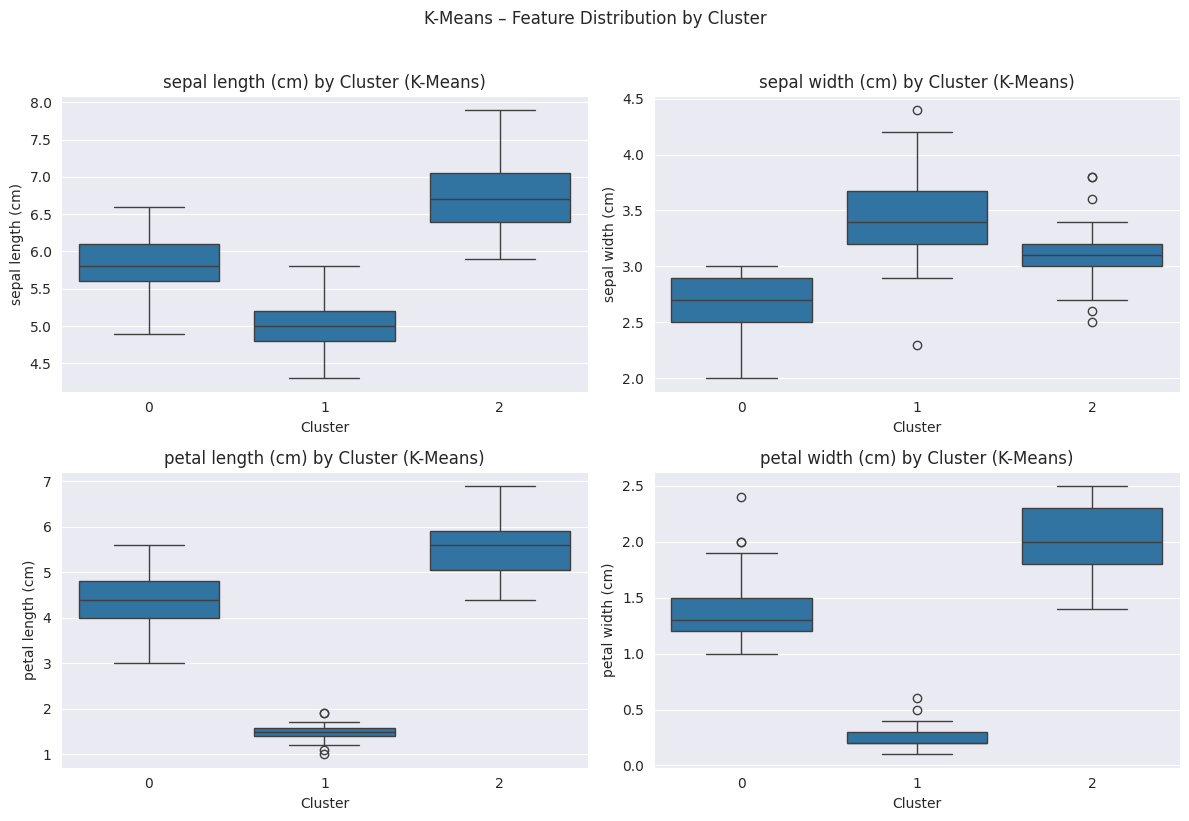

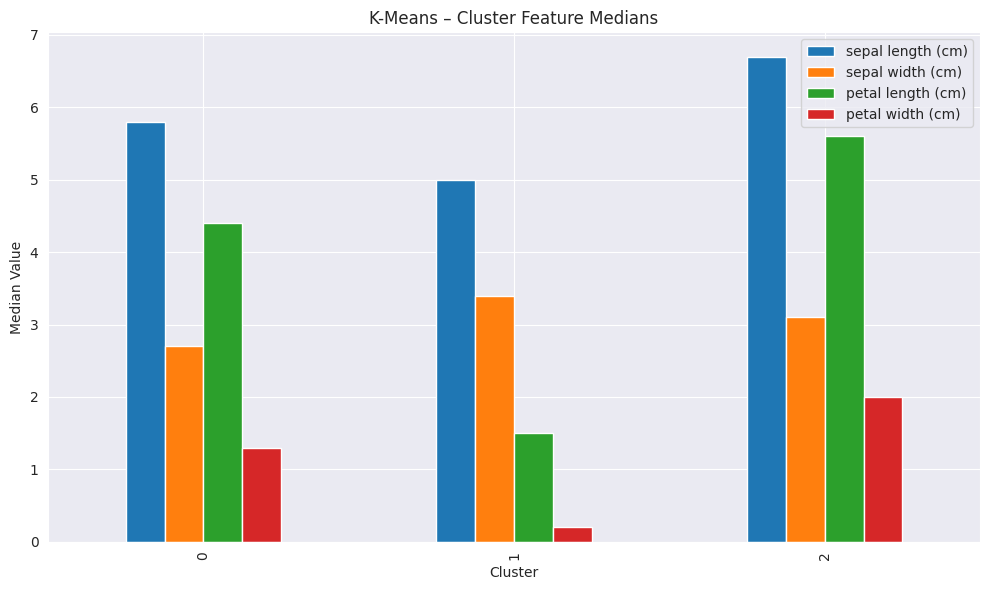


===== DBSCAN Cluster Profiling =====
         sepal length (cm)  sepal width (cm)  petal length (cm)  \
Cluster                                                           
0                     5.00               3.4               1.50   
1                     6.25               2.9               4.85   

         petal width (cm)  
Cluster                    
0                    0.20  
1                    1.55  


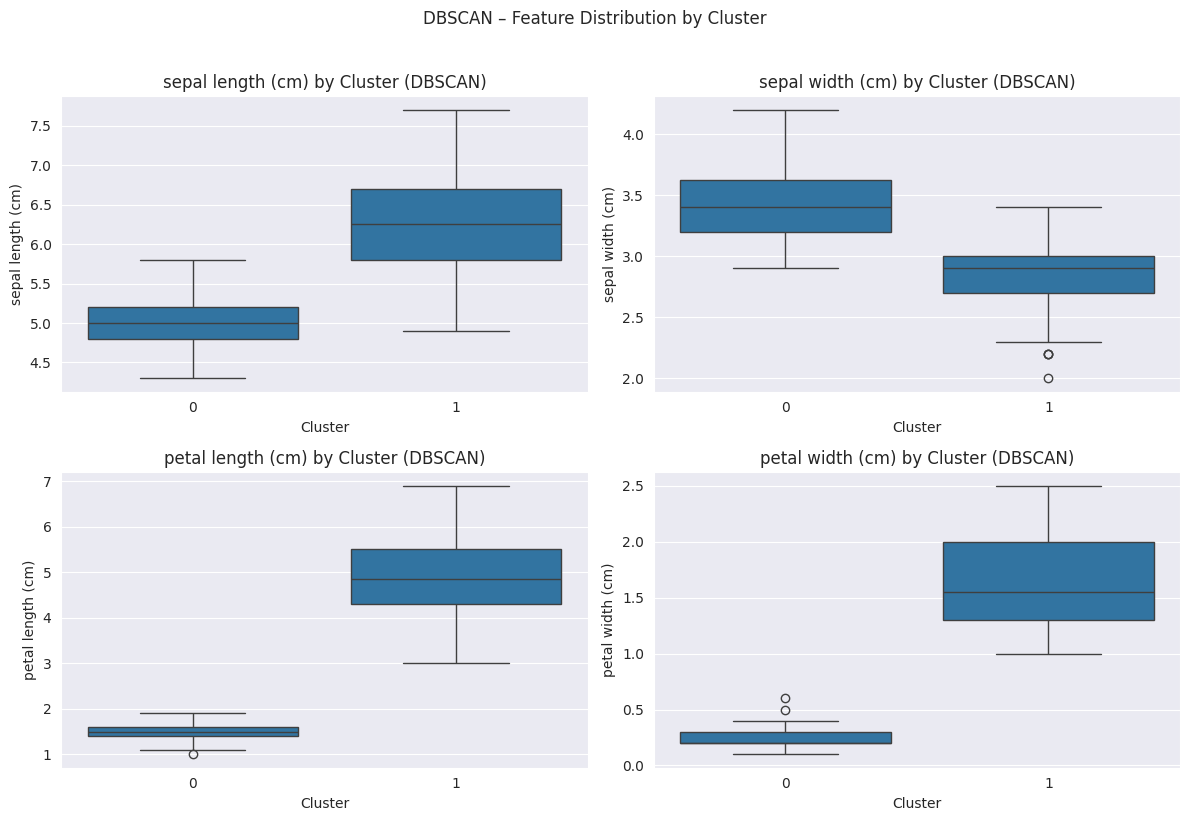

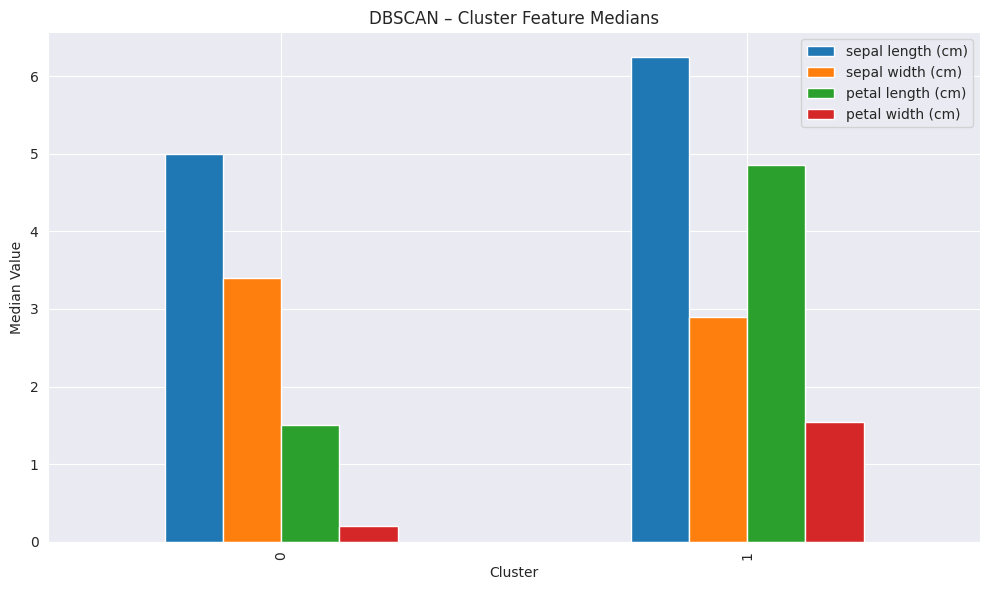


===== Agglomerative Cluster Profiling =====
         sepal length (cm)  sepal width (cm)  petal length (cm)  \
Cluster                                                           
0                      6.4              3.00                5.1   
1                      5.0              3.40                1.5   
2                      5.6              2.55                4.0   

         petal width (cm)  
Cluster                    
0                    1.80  
1                    0.20  
2                    1.25  


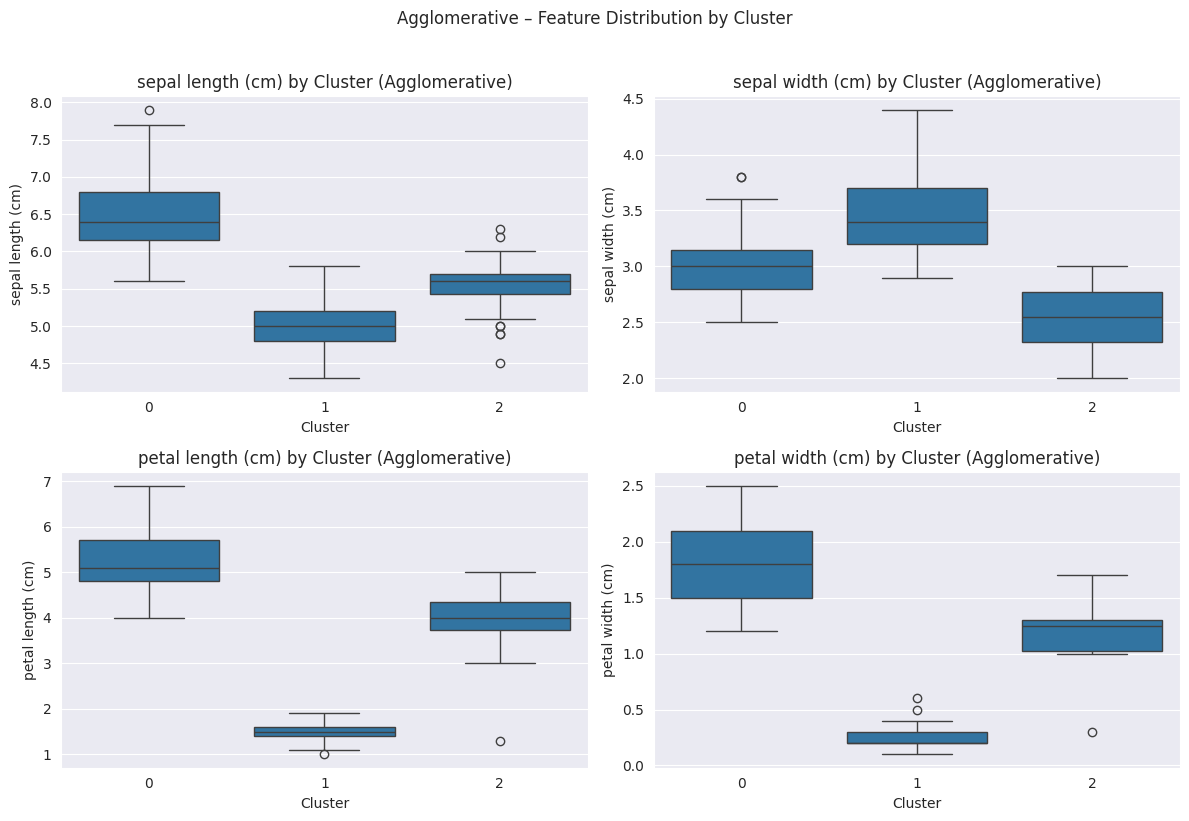

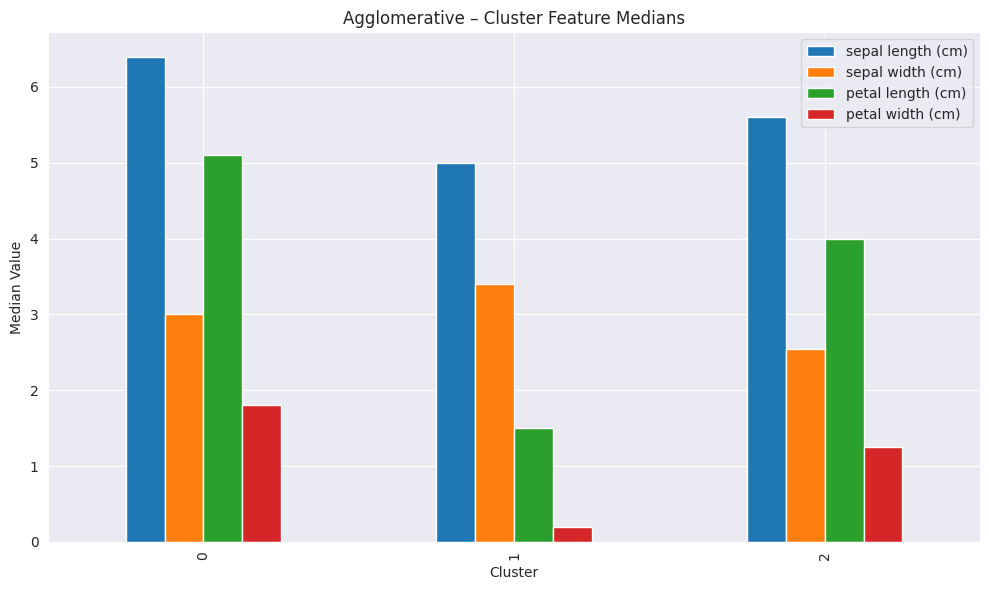

In [84]:
# Original feature names
features = iris.columns[:-1]  # exclude 'target'

# Clustering results
algorithms = {
    "K-Means": kmeans_labels,
    "DBSCAN": dbs_labels,
    "Agglomerative": agg_labels,
}

for name, labels in algorithms.items():
    print(f"\n===== {name} Cluster Profiling =====")

    df = iris.copy()
    df['Cluster'] = labels

    # Remove noise points (-1) for DBSCAN
    df_filtered = df[df['Cluster'] != -1]

    # Compute median feature values per cluster
    cluster_medians = df_filtered.groupby("Cluster")[features].median()
    print(cluster_medians)

    # Boxplots
    plt.figure(figsize=(12, 8))
    for i, column in enumerate(features):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(x="Cluster", y=column, data=df_filtered)
        plt.title(f"{column} by Cluster ({name})")
    plt.suptitle(f"{name} – Feature Distribution by Cluster", y=1.02)
    plt.tight_layout()
    plt.show()

    # Barplot of medians
    cluster_medians.plot(kind='bar', figsize=(10, 6))
    plt.title(f"{name} – Cluster Feature Medians")
    plt.ylabel("Median Value")
    plt.xlabel("Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Exercise

   * Which clustering do you prefer and why?  
   * Does it line up with the botanical species?  
   * Any limitations or next steps?

This section analyzes the internal structure of clusters produced by **K-Means**, **DBSCAN**, and **Agglomerative Clustering**. We use **feature medians** and **visualizations** (boxplots and bar charts) to describe the characteristics of each cluster.

---

#### K-Means Cluster Profiling

**Insights:**
- Cluster 1: small petal dimensions, wide sepals → likely *Iris-setosa*.
- Cluster 2: large petals and longer sepals → likely *Iris-virginica*.
- Cluster 0: intermediate values → likely *Iris-versicolor*.

---

#### DBSCAN Cluster Profiling

**Insights:**
- Cluster 0 contains compact points with very small petal dimensions → strongly corresponds to *Iris-setosa*.
- Cluster 1 represents a broader group, mixing characteristics of *versicolor* and *virginica*.
- DBSCAN also excludes noise points (not shown in medians), offering robustness to outliers.

---

#### Agglomerative Clustering Profiling

**Insights:**
- Cluster 1: matches *Iris-setosa* (short, narrow petals).
- Cluster 0: long and wide petals → consistent with *virginica*.
- Cluster 2: intermediate traits → likely *versicolor*, though slightly more overlap with *virginica* than in K-Means.

---

### Summary

- **K-Means** provides well-separated and interpretable clusters, clearly matching the three Iris species.
- **DBSCAN** discovers two dense groups, successfully isolates *setosa*, and avoids noisy points, but merges *versicolor* and *virginica*.
- **Agglomerative Clustering** captures hierarchy well and forms biologically meaningful groups, though *versicolor* may appear more mixed.

**Cluster profiling** adds interpretability to unsupervised results by linking cluster identities with actual feature patterns.
